In [1]:
import os
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper

In [49]:
epoch_folder = "/Users/olledejong/Documents/MSc_Biology/ResearchProject2/rp2_data/resting_state/output/epochs"
plot_folder = "/Users/olledejong/Documents/MSc_Biology/ResearchProject2/rp2_data/resting_state/output/plots"

Load the epoch files

In [4]:
epoch_objects = []
for file in os.listdir(epoch_folder):
    if not file.endswith("epo.fif") or file.startswith("raw"):
        print(f"Skipping {file}")
        continue
    epoch_objects.append(mne.read_epochs(os.path.join(epoch_folder, file), preload=False))

Skipping raw_epochs_resting_state_78227-epo.fif
Skipping raw_epochs_resting_state_78211-epo.fif
Skipping raw_epochs_resting_state_79593-epo.fif
Skipping raw_epochs_resting_state_79592-epo.fif
Skipping raw_epochs_resting_state_78244-epo.fif
Skipping raw_epochs_resting_state_39508-epo.fif
Skipping raw_epochs_resting_state_79602-epo.fif
Skipping raw_epochs_resting_state_80620-epo.fif
Skipping raw_epochs_resting_state_80630-epo.fif
Skipping raw_epochs_resting_state_81207-epo.fif
Skipping raw_epochs_resting_state_81217-epo.fif
Skipping raw_epochs_resting_state_39489-epo.fif
Skipping raw_epochs_resting_state_81175-epo.fif
Skipping raw_epochs_resting_state_80625-epo.fif
Skipping raw_epochs_resting_state_81193-epo.fif
Skipping raw_epochs_resting_state_78233-epo.fif
Skipping raw_epochs_resting_state_81218-epo.fif
Skipping raw_epochs_resting_state_79604-epo.fif


In [5]:
filtered_epochs_WT = []
filtered_epochs_KO = []

# split WT and KO epoch objects
[filtered_epochs_WT.append(object) if object.metadata["genotype"][0] == "DRD2-WT" else filtered_epochs_KO.append(object) for object in epoch_objects]
print(len(filtered_epochs_WT), len(filtered_epochs_KO))

8 10


In [ ]:
# concatenate the epochs per genotype
wt_epochs = mne.concatenate_epochs(filtered_epochs_WT, add_offset=True)
ko_epochs = mne.concatenate_epochs(filtered_epochs_KO, add_offset=True)

In [36]:
print(f"Number of DRD2-WT and DRD2-KO epochs, respectively: {len(wt_epochs)}, {len(ko_epochs)}")

Number of DRD2-WT and DRD2-KO epochs, respectively: 14059, 14184


Let's report the average number of epochs that passed the filtering (WT vs KO) 

In [49]:
num_epochs_wt = [len(epoch_obj) for epoch_obj in filtered_epochs_WT]
num_epochs_ko = [len(epoch_obj) for epoch_obj in filtered_epochs_KO]
print("Average number of epochs for DRD2-WT subjects: ", np.mean(num_epochs_wt))
print("Average number of epochs for DRD2-KO subjects: ", np.mean(num_epochs_ko))

Average number of epochs for DRD2-WT subjects:  1757.375
Average number of epochs for DRD2-KO subjects:  1418.4


In [50]:
freqs = np.array([])
# we want to plot for every channel
df_av_psds_WT = pd.DataFrame([])
df_av_psds_KO = pd.DataFrame([])
for channel in filtered_epochs_WT[0].info["ch_names"]:
    if channel in ['EMG_L', 'EMG_R']:
        continue
        
    channel_psds_WT = pd.DataFrame([])
    channel_psds_KO = pd.DataFrame([])
    
    # loop through all WT subjects/epoch arrays
    for i in range(len(filtered_epochs_WT)):
        subj_epochs_WT = filtered_epochs_WT[i]
        id_WT = subj_epochs_WT.metadata["animal_id"][0]
        psds_WT, freqs = psd_array_multitaper(subj_epochs_WT.get_data(picks=channel), fmin=0, fmax=100, sfreq=subj_epochs_WT.info['sfreq'], n_jobs=-1)
        channel_psds_WT[id_WT] = np.mean(psds_WT[:, 0, :], axis=0)  # take the average of the psds of all epochs

    # loop through all KO subjects/epoch arrays
    for j in range(len(filtered_epochs_KO)):
        subj_epochs_KO = filtered_epochs_KO[j]
        id_KO = subj_epochs_KO.metadata["animal_id"][0]
        psds_KO, freqs = psd_array_multitaper(subj_epochs_KO.get_data(picks=channel), fmin=0, fmax=100, sfreq=subj_epochs_KO.info['sfreq'], n_jobs=-1)
        channel_psds_KO[id_KO] = np.mean(psds_KO[:, 0, :], axis=0)  # take the average of the psds of all epochs
    
    df_av_psds_WT['freqs'] = freqs
    df_av_psds_KO['freqs'] = freqs
    df_av_psds_WT[channel] = channel_psds_WT.mean(axis=1)
    df_av_psds_KO[channel] = channel_psds_KO.mean(axis=1)

    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spectrum estimation with 7 DPSS windows
    Using multitaper spe

In [67]:
freqs = df_av_psds_WT.freqs
for col in df_av_psds_WT.columns[1:]:
    converted_psd_wt = 10 * np.log10(df_av_psds_WT[col])  # transform to decibels?
    converted_psd_ko = 10 * np.log10(df_av_psds_KO[col])

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(freqs, converted_psd_wt, label='DRD2-WT')
    ax.plot(freqs, converted_psd_ko, label='DRD2-KO')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power/Frequency (dB/Hz)')
    ax.set_title(f'Average PSD - Channel {col}')
    plt.legend()
    plt.savefig(os.path.join(plot_folder, f"/averaged_per_subject/psd_wt_vs_ko_{col}.png"), dpi=300, bbox_inches='tight') 

NameError: name 'df_av_psds_WT' is not defined

Now, instead of averaging the psd per epochs per channel per subject, let's try to concatenate the epochs of the genotypes and take the average psd of all epochs of one channel.

In [ ]:
for chan in [wt_epochs.info["ch_names"]]:
    if chan in ['EMG_L', 'EMG_R']:
        continue
    psds_wt, freqs = psd_array_multitaper(wt_epochs.get_data(picks=chan), fmin=0, fmax=100, sfreq=wt_epochs.info['sfreq'])
    psds_ko, freqs = psd_array_multitaper(ko_epochs.get_data(picks=chan), fmin=0, fmax=100, sfreq=ko_epochs.info['sfreq'])
    
    mean_psd_wt = np.mean(psds_wt[:, 0, :], axis=0)
    mean_psd_ko = np.mean(psds_ko[:, 0, :], axis=0)
    
    conf_int_wt = 1.96 * np.std(psds_wt[:, 0, :], axis=0) / np.sqrt(psds_wt.shape[0])  # 95% confidence interval
    conf_int_ko = 1.96 * np.std(psds_ko[:, 0, :], axis=0) / np.sqrt(psds_ko.shape[0])  # 95% confidence interval

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(freqs, 10 * np.log10(mean_psd_wt), label='DRD2-WT')
    ax.plot(freqs, 10 * np.log10(mean_psd_ko), label='DRD2-KO')
    ax.fill_between(freqs, 10 * np.log10(mean_psd_wt - conf_int_wt), 10 * np.log10(mean_psd_wt + conf_int_wt), alpha=0.2, label='95% CI')
    ax.fill_between(freqs, 10 * np.log10(mean_psd_ko - conf_int_ko), 10 * np.log10(mean_psd_ko + conf_int_ko), alpha=0.2, label='95% CI')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power/Frequency (dB/Hz)')
    ax.set_title(f'Average PSD - Channel {chan}')
    plt.legend()
    plt.savefig(os.path.join(plot_folder, f"/averaged_all_epochs/psd_wt_vs_ko_{chan}.png"), dpi=300, bbox_inches='tight') 

Let's generate a PSD overview plot for both WT and KO subjects

IndexError: index 8 is out of bounds for axis 0 with size 8

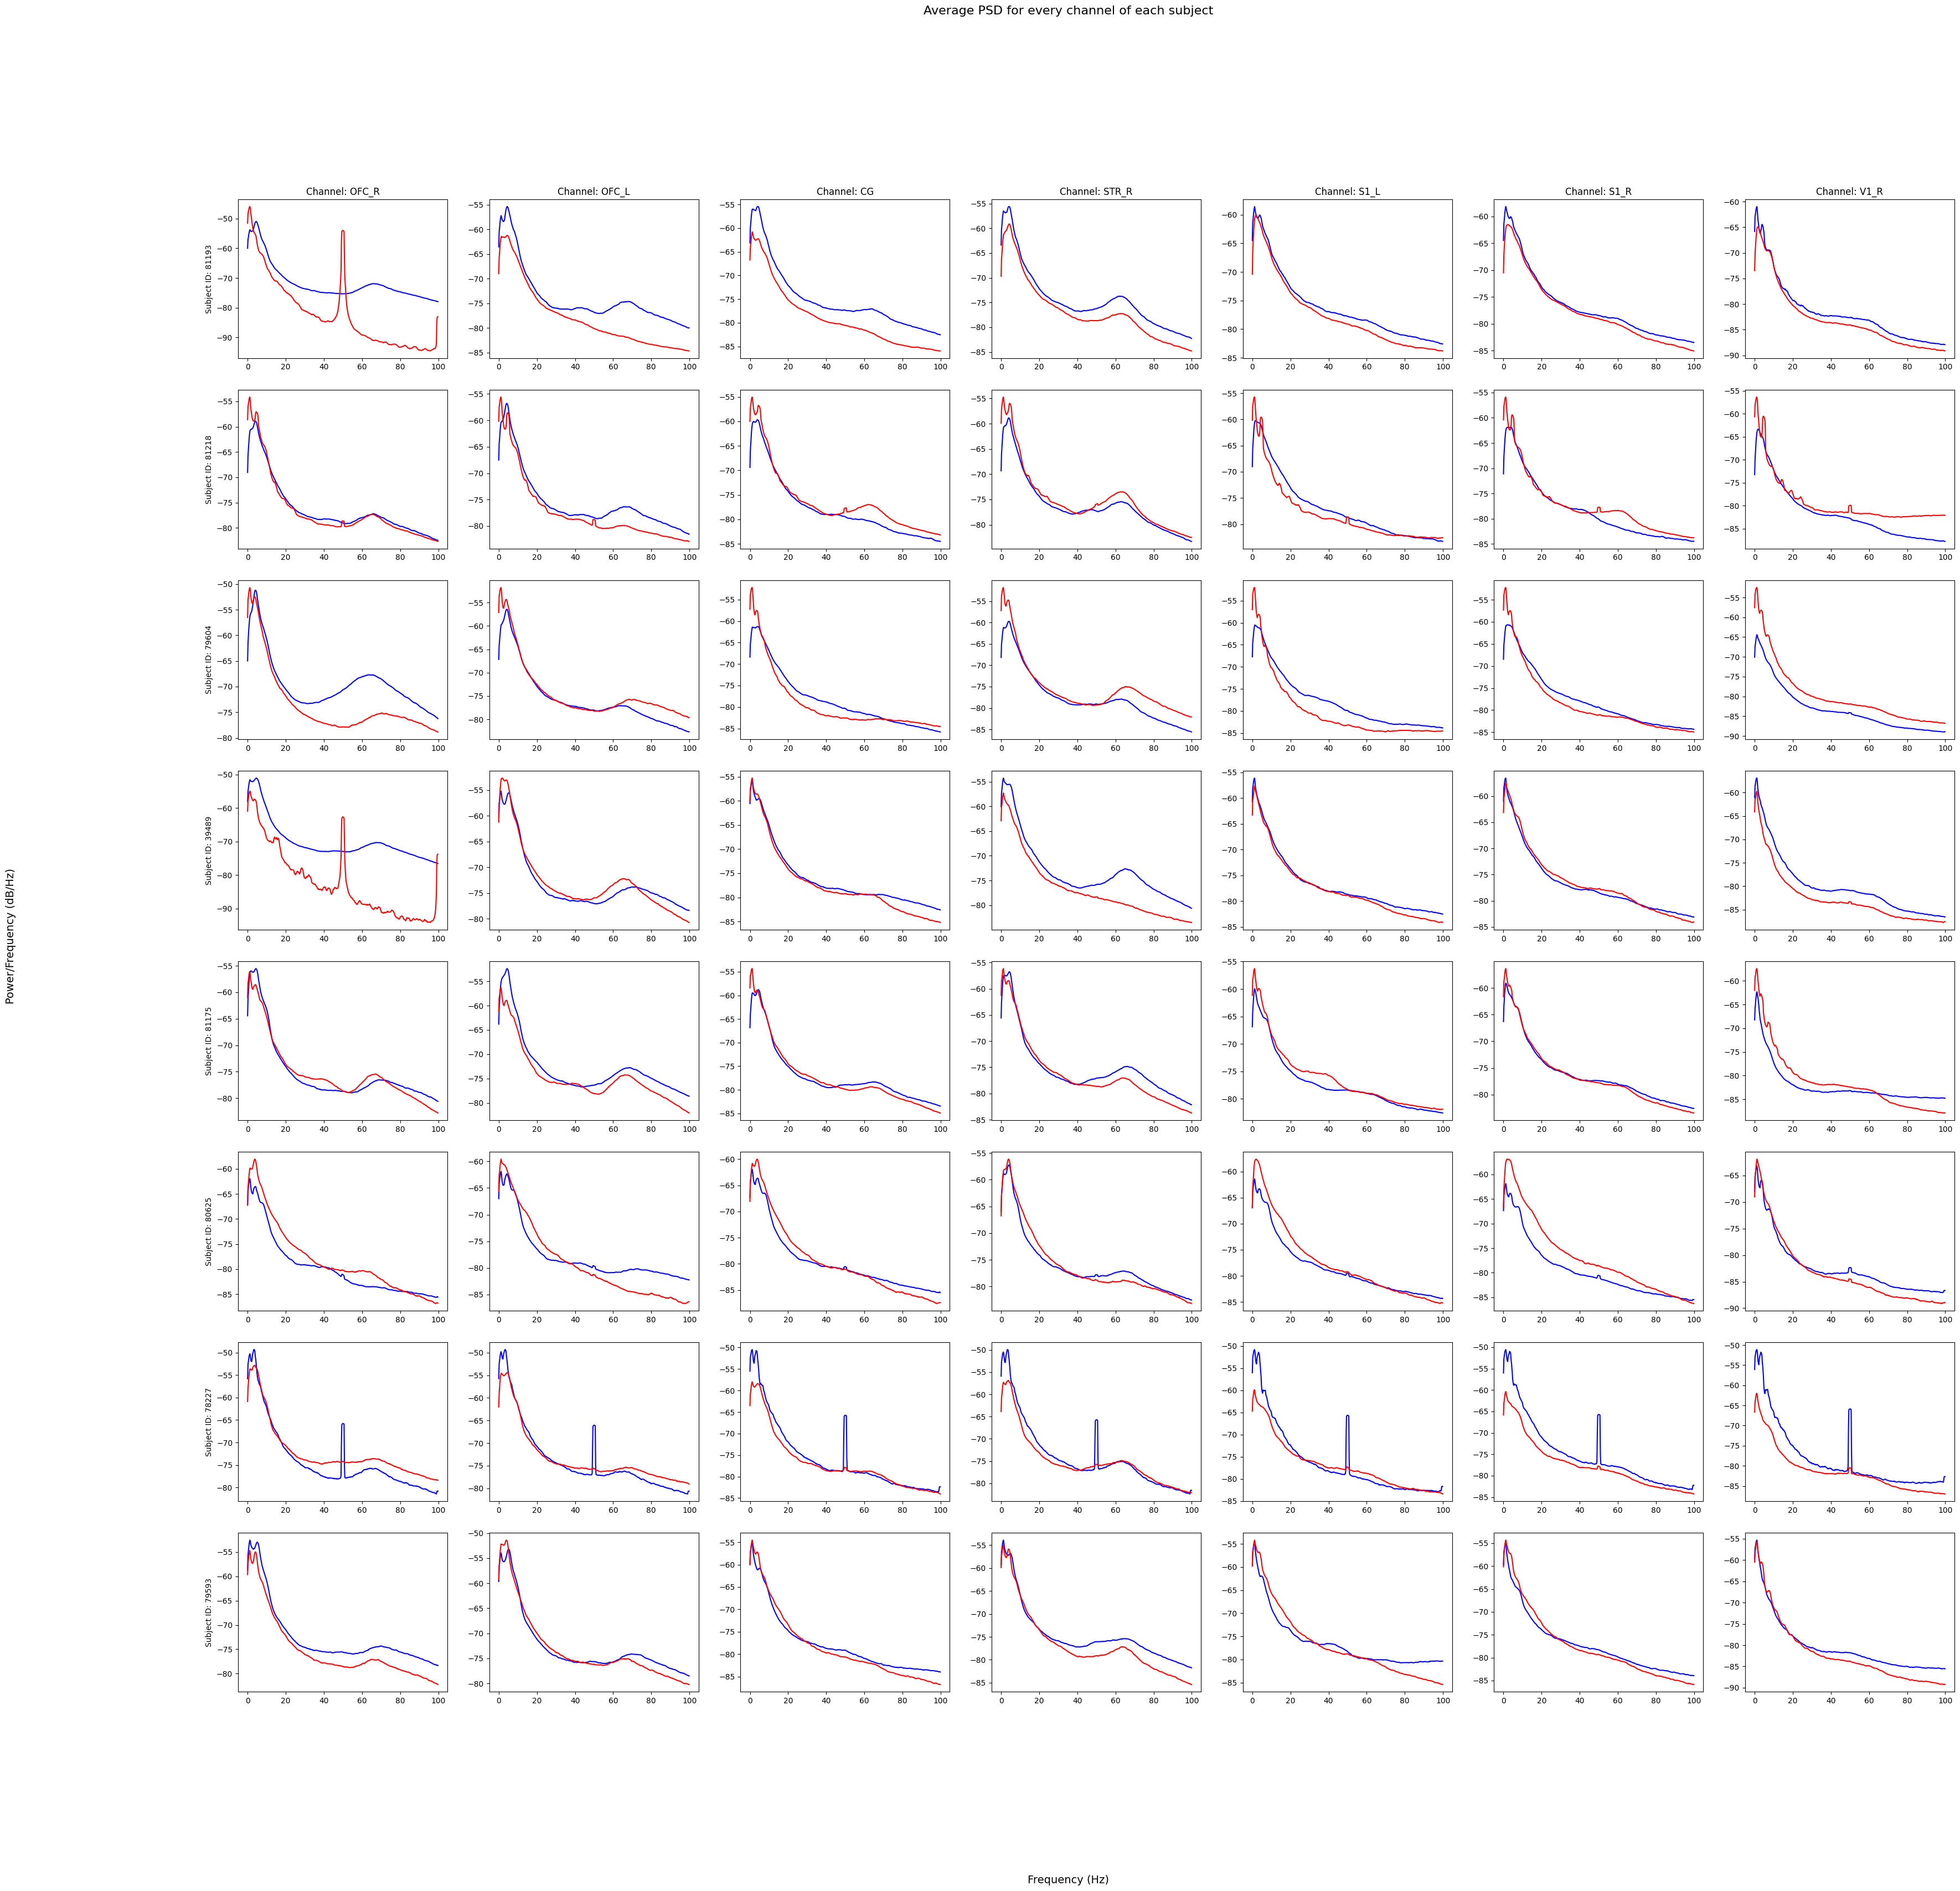

In [66]:
for genotype_epochs in [filtered_epochs_WT, filtered_epochs_KO]:
    wanted_chans = [channel for channel in genotype_epochs[0].info["ch_names"] if not channel in ['EMG_L', 'EMG_R']]
    num_cols = len(filtered_epochs_WT)
    fig, axs = plt.subplots(num_cols, len(wanted_chans), figsize=(5 * num_cols, 5 * len(wanted_chans)))
    genotype = genotype_epochs[0].metadata['genotype'][0]
    
    for i, subject_epochs in enumerate(genotype_epochs):
        for j, chan in enumerate(wanted_chans):
            
            id = subject_epochs.metadata["animal_id"][0]
            psds, freqs = psd_array_multitaper(subject_epochs.get_data(picks=chan), fmin=0, fmax=100, sfreq=subject_epochs.info['sfreq'], n_jobs=-1)
            mean_psd = np.mean(psds[:, 0, :], axis=0)
            
            axs[i, j].plot(freqs, 10 * np.log10(mean_psd), label='Average PSD', color=('r' if genotype == "DRD2-KO" else 'b'))
            if j == 0:
                axs[i, j].set_ylabel(f'Subject ID: {id}')
            if i == 0:
                axs[i, j].set_title(f'Channel: {chan}')
            
    fig.supxlabel('Frequency (Hz)', fontsize=14)
    fig.supylabel('Power/Frequency (dB/Hz)', fontsize=14)
    fig.suptitle("Average PSD for every channel of each subject", fontsize=16)
    
    plt.savefig(os.path.join(plot_folder, f"grid_psd_filtered_epochs_{genotype}.png"), dpi=300, bbox_inches='tight')